In [1]:
import sys
sys.path.append("../model/")

import gc
import joblib
import random

import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)

import matplotlib.pyplot as plt
import seaborn as sns

import optuna

from utils import csi_score, show_cm, print_metrics
from HurdleTreeModel import HurdleTreeModel

# Data

In [2]:
train_data = pd.read_csv('../data/train_final.csv')

In [3]:
print(train_data.shape[0])
train_data.dropna(axis = 0, inplace = True)
train_data.reset_index(drop = True, inplace = True)
print(train_data.shape[0])

3156459
3109248


In [4]:
train_data

,stn_id,year,month,day,time,minute,FirstLetter,SecondLetter,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,vis1,class,MDay,TM,cosMD,sinMD,cosTM,sinTM
0,AA,2020,1,1,0,10,A,A,0.0,0.0,-6.4,0.0,38.9,0.0,-2.8,20000.0,4.0,1,10,0.999852,1.721336e-02,0.999048,0.043619
1,AA,2020,1,1,0,20,A,A,0.0,0.0,-6.3,0.0,37.9,0.0,-2.7,20000.0,4.0,1,20,0.999852,1.721336e-02,0.996195,0.087156
2,AA,2020,1,1,0,30,A,A,0.0,0.0,-6.3,0.0,40.0,0.0,-2.6,20000.0,4.0,1,30,0.999852,1.721336e-02,0.991445,0.130526
3,AA,2020,1,1,0,40,A,A,27.8,0.4,-6.2,0.0,39.5,0.0,-2.6,20000.0,4.0,1,40,0.999852,1.721336e-02,0.984808,0.173648
4,AA,2020,1,1,0,50,A,A,59.7,0.5,-6.1,0.0,39.8,0.0,-2.5,20000.0,4.0,1,50,0.999852,1.721336e-02,0.976296,0.216440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3109243,EC,2022,12,31,23,10,E,C,305.3,7.7,2.5,0.0,50.2,0.0,-0.9,20000.0,4.0,365,1390,1.000000,6.432571e-16,0.976296,-0.216440
3109244,EC,2022,12,31,23,20,E,C,293.8,5.7,2.3,0.0,50.1,0.0,-1.3,20000.0,4.0,365,1400,1.000000,6.432571e-16,0.984808,-0.173648
3109245,EC,2022,12,31,23,30,E,C,274.2,4.9,2.2,0.0,51.0,0.0,-1.4,20000.0,4.0,365,1410,1.000000,6.432571e-16,0.991445,-0.130526
3109246,EC,2022,12,31,23,40,E,C,270.3,4.6,2.1,0.0,51.7,0.0,-1.6,20000.0,4.0,365,1420,1.000000,6.432571e-16,0.996195,-0.087156


## 파생 변수

In [5]:
## 4월 ~ 10월 -> 1 / 나머지 -> 0
def split_half(x):
    if x in [i for i in range(4, 11, 1)]:
        return 1
    return 0

def gen_derived_variables(df):
    # ta - ts
    df['ta-ts'] = df['ta'] - df['ts']

    ## 풍속 / 습도
    df['hmws10'] = df['ws10_ms'] / (df['hm'] + 1e-7)

    a = 17.62
    b = 243.12
    ta = df['ta']
    log_hm = np.log((df['hm'] + 1e-7) / 100)
    son =  b * (log_hm + (a * ta) / (b + ta))
    mother = a - (log_hm + (a * ta) / (b + ta))
    df['dew'] = son / mother

    ## 4월 ~ 10월 -> 1 / 나머지 -> 0
    df['half'] = df['month'].apply(split_half)

    ## ta / ln(hm + 1)
    hm = df['hm']
    df['ta_lnhm'] = ta / np.log(hm + 100)

    ## ta < 이슬점 + 0.35
    dew = df['dew']
    df['sup_dew'] = ta < (dew + 0.35)
    
    return df.copy()

In [6]:
train_data = gen_derived_variables(train_data)

# Model

## defualt params for models

XGB<br>
<br>max_depth=3
<br>learning_rate=0.1
<br>n_estimators=100
<br>silent=True
<br>objective='binary:logistic'
<br>booster='gbtree'
<br>n_jobs=1
<br>nthread=None
<br>gamma=0
<br>min_child_weight=1
<br>max_delta_step=0
<br>subsample=1
<br>colsample_bytree=1
<br>colsample_bylevel=1
<br>reg_alpha=0
<br>reg_lambda=1
<br>scale_pos_weight=1
<br>base_score=0.5
<br>random_state=0
<br>seed=None
<br>missing=None
<br>https://resultofeffort.tistory.com/108

LGBM <br>
https://for-my-wealthy-life.tistory.com/24

Random Forest<br>
https://injo.tistory.com/30<br>
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

## Optuna

In [9]:
# 난수 고정 함수 선언
def seed_everything(SEED):
    random.seed(SEED)
    np.random.seed(SEED)
    return None

In [10]:
def objective(trial, data):
    # 난수 생성 시드 지정
    SEED = 630

    # 파라미터 공간 초기화
    params_1stage = dict(
        XGB = dict(A = None, B = None, C = None, D = None, E = None),
        LGBM = dict(A = None, B = None, C = None, D = None, E = None),
        RNF = dict(A = None, B = None, C = None, D = None, E = None)
    )
    params_2stage = dict(
        XGB = dict(A = None, B = None, C = None, D = None, E = None),
        LGBM = dict(A = None, B = None, C = None, D = None, E = None),
        RNF = dict(A = None, B = None, C = None, D = None, E = None)        
    )
    params = dict(
        params_1stage = None,
        params_2stage = None
    )

    # 각 stage 별 사용 할 모델 추천
    seed_everything(SEED)
    model_1stage_optuna = trial.suggest_categorical('model_1stage', choices = ['XGB', 'LGBM', 'RNF'])
    model_2stage_optuna = trial.suggest_categorical('model_2stage', choices = ['XGB', 'LGBM', 'RNF'])
    
    # 모델 파라미터 추천
    for stn in ['A', 'B', 'C', 'D', 'E']:
        # 자원 사용 관련
        params_1stage['XGB'][stn] = {
            'random_state' : SEED,
            'tree_method'  : 'gpu_hist', # gpu 사용
            'gpu_id' : 0               # gpu 사용
        }
        params_2stage['XGB'][stn] = {
            'random_state' : SEED,
            'tree_method'  : 'gpu_hist', # gpu 사용
            'gpu_id' : 0               # gpu 사용
        }        
        params_1stage['LGBM'][stn] = {
            'random_state' : SEED,
            'device' : 'gpu' # GPU 사용
        }
        params_2stage['LGBM'][stn] = {
            'random_state' : SEED,
            'device' : 'gpu' # GPU 사용
        }        
        params_1stage['RNF'][stn] = {
            'random_state' : SEED
        }
        params_2stage['RNF'][stn] = {
            'random_state' : SEED
        }
        # optuna parameter space
        if model_1stage_optuna == 'XGB':
            params_1stage['XGB'][stn] = {
                # XGB - params spaces
                'max_depth'         : trial.suggest_int('max_depth_1stage_XGB_' + stn, 1, 20), # 트리의 최대 깊이
                'learning_rate'     : trial.suggest_float('learning_rate_1stage_XGB_' + stn, 0.01, 0.1, log = True), 
                'n_estimators'      : trial.suggest_int('n_estimators_1stage_XGB_' + stn, 50, 200),
                'gamma'             : trial.suggest_float('gamma_1stage_XGB_' + stn, 0, 1), # leaf 노드에서 추가 분할을 수행 하기 위해 필요한 최소 손실 감소량(큰값 : 과적합 방지)
                'min_child_weight'  : trial.suggest_float('min_child_weight_1stage_XGB_' + stn, 1, 3),  # 각 리프 노드에서 최소한의 샘플 가중치 합을 지정
                'max_delta_step'    : trial.suggest_float('max_delta_step_1stage_XGB_' + stn, 0, 10),   # 각 리프 노드의 출력값이 허용되는 최대 변화량
                'reg_alpha'         : trial.suggest_float('reg_alpha_1stage_XGB_' + stn, 0, 1),  # L1 정규화
                'reg_lambda'        : trial.suggest_float('reg_lambda_1stage_XGB_' + stn, 0, 1)  # L2 정규화
            }
        if model_2stage_optuna == 'XGB':
            params_2stage['XGB'][stn] = {
                # XGB params spaces
                'max_depth'         : trial.suggest_int('max_depth_2stage_XGB_' + stn, 1, 20), # 트리의 최대 깊이
                'learning_rate'     : trial.suggest_float('learning_rate_2stage_XGB_' + stn, 0.01, 0.1, log = True), 
                'n_estimators'      : trial.suggest_int('n_estimators_2stage_XGB_' + stn, 50, 200),
                'gamma'             : trial.suggest_float('gamma_2stage_XGB_' + stn, 0, 1), # leaf 노드에서 추가 분할을 수행 하기 위해 필요한 최소 손실 감소량(큰값 : 과적합 방지)
                'min_child_weight'  : trial.suggest_float('min_child_weight_2stage_XGB_' + stn, 1, 3),  # 각 리프 노드에서 최소한의 샘플 가중치 합을 지정
                'max_delta_step'    : trial.suggest_float('max_delta_step_2stage_XGB_' + stn, 0, 10),   # 각 리프 노드의 출력값이 허용되는 최대 변화량
                'reg_alpha'         : trial.suggest_float('reg_alpha_2stage_XGB_' + stn, 0, 1),  # L1 정규화
                'reg_lambda'        : trial.suggest_float('reg_lambda_2stage_XGB_' + stn, 0, 1)  # L2 정규화         
            }        
        if model_1stage_optuna == 'LGBM':
            params_1stage['LGBM'][stn] = {
                # LGBM params spaces
                'learning_rate'     : trial.suggest_float('learning_rate_1stage_LGBM_' + stn, 0.01, 0.1, log = True),
                'max_depth'         : trial.suggest_int('max_depth_1stage_LGBM_' + stn, 1, 10),
                'min_child_samples' : trial.suggest_int('min_child_samples_1stage_LGBM_' + stn, 10, 50),
                'num_leaves'        : trial.suggest_int('num_leaves_1stage_LGBM_' + stn, 20, 50),
                'reg_alpha'         : trial.suggest_float('reg_alpha_1stage_LGBM_' + stn, 0, 1), # L1 정규화
                'reg_lambda'        : trial.suggest_float('reg_lambda_1stage_LGBM_' + stn, 0, 1)  # L2 정규화
            }
        if model_2stage_optuna == 'LGBM':
            params_2stage['LGBM'][stn] = {
                # LGBM params spaces
                'learning_rate'     : trial.suggest_float('learning_rate_2stage_LGBM_' + stn, 0.01, 0.1, log = True),
                'max_depth'         : trial.suggest_int('max_depth_2stage_LGBM_' + stn, 1, 10),
                'min_child_samples' : trial.suggest_int('min_child_samples_2stage_LGBM_' + stn, 10, 50),
                'num_leaves'        : trial.suggest_int('num_leaves_2stage_LGBM_' + stn, 20, 50),
                'reg_alpha'         : trial.suggest_float('reg_alpha_2stage_LGBM_' + stn, 0, 1), # L1 정규화
                'reg_lambda'        : trial.suggest_float('reg_lambda_2stage_LGBM_' + stn, 0, 1)  # L2 정규화            
            }        
        if model_1stage_optuna == 'RNF':
            params_1stage['RNF'][stn] = {
                # Random Forest params spaces
                'n_estimators' : trial.suggest_int('n_estimators_1stage_RNF_' + stn, 10, 100),
                'min_samples_split' : trial.suggest_int('min_samples_split_1stage_RNF_' + stn, 2, 10),
                'min_samples_leaf' : trial.suggest_int('min_samples_leaf_1stage_RNF_' + stn, 1, 5),
                'max_depth' : trial.suggest_int('max_depth_1stage_RNF_' + stn, 5, 30),
                'max_leaf_nodes' : trial.suggest_int('max_leaf_nodes_1stage_RNF_' + stn, 10, 50)
            }
        if model_2stage_optuna == 'RNF':
            params_2stage['RNF'][stn] = {
                # Random Forest params spaces
                'random_state' : SEED,
                'n_estimators' : trial.suggest_int('n_estimators_2stage_RNF_' + stn, 10, 100),
                'min_samples_split' : trial.suggest_int('min_samples_split_2stage_RNF_' + stn, 2, 10),
                'min_samples_leaf' : trial.suggest_int('min_samples_leaf_2stage_RNF_' + stn, 1, 5),
                'max_depth' : trial.suggest_int('max_depth_2stage_RNF_' + stn, 5, 30),
                'max_leaf_nodes' : trial.suggest_int('max_leaf_nodes_2stage_RNF_' + stn, 10, 50)            
            }         
    
    params['params_1stage'] = params_1stage
    params['params_2stage'] = params_2stage
    
    
    # 모델 선언
    hurdle_tree = HurdleTreeModel(params = params)
    
    # 데이터 준비
    # I -> 2020년, J -> 2021년, K -> 2022년
    train = data.loc[(data['year'] == 2020) | (data['year'] == 2021)].copy()
    valid = data.loc[data['year'] == 2022].copy()
    train.reset_index(drop = True, inplace = True)
    valid.reset_index(drop = True, inplace = True)
    # Y 값 변환
    train_1stage = hurdle_tree.gen_1stage_data(train)
    train_2stage = hurdle_tree.gen_2stage_data(train)
    valid_1stage = hurdle_tree.gen_1stage_data(valid)
    # valid_2stage = hurdle_tree.gen_2stage_data(valid)
    
    # 지역 구분을 위해 FirstLetter 필요
    drop_cols = ['year', 'month', 'day', 'time', 'minute', # 시간 관련 변수 -> cos/sin MD/TM 으로 압축
                'stn_id', 'SecondLetter', # 지역 변수
                'vis1', 'class'] # 타겟 변수
    
    # stage별 학습 데이터 생성
    x_train_1stage = train_1stage.drop(drop_cols, axis = 1, inplace = False).copy()
    y_train_1stage = train_1stage['class'].copy()
    x_train_2stage = train_2stage.drop(drop_cols, axis = 1, inplace = False).copy()
    y_train_2stage = train_2stage['class'].copy()
    x_valid_1stage = valid_1stage.drop(drop_cols, axis = 1, inplace = False).copy()
    y_valid_1stage = valid_1stage['class'].copy()

    # CSI 스코어 도출용 검증 데이터
    x_valid = valid.drop(drop_cols, axis = 1, inplace = False).copy()
    y_valid = valid['class'].copy()
    
    # 사용하지 않는 모델 제거
    for model in ['XGB', 'LGBM', 'RNF']:
        if model != model_1stage_optuna:
            del hurdle_tree.model_1stage[model]
    for model in ['XGB', 'LGBM', 'RNF']:
        if model != model_2stage_optuna:
            del hurdle_tree.model_2stage[model] 

    # 1 stage 학습
    hurdle_tree.fit_1stage(x_train_1stage, y_train_1stage)
    _ = hurdle_tree.set_cutoff(x_valid_1stage, y_valid_1stage) # 모델 / 지역 별 cutoff 값 return
    hurdle_tree.fit_2stage(x_train_2stage, y_train_2stage)
    
    # 2 stage 학습
    hurdle_tree.set_1stage_model(model_1stage_optuna)
    hurdle_tree.set_2stage_model(model_2stage_optuna)
    
    y_pred = hurdle_tree.predict_oneshot(x_valid)
    score = csi_score(y_valid, y_pred)
    
    # 객체 삭제
    del hurdle_tree
    # 메모리 공간 확보
    gc.collect()
    
    return score

In [28]:
# 100 trial -> 
study = optuna.create_study(direction = 'maximize')
study.optimize(lambda trial: objective(trial, train_data), n_trials = 100) # optuna 실행

[I 2024-06-21 17:23:35,253] A new study created in memory with name: no-name-562c5e30-8d54-43e5-ac18-3cd01afc5da3
[I 2024-06-21 17:24:58,692] Trial 0 finished with value: 0.05787580165783718 and parameters: {'model_1stage': 'XGB', 'model_2stage': 'XGB', 'max_depth_1stage_XGB_A': 16, 'learning_rate_1stage_XGB_A': 0.07490833149531782, 'n_estimators_1stage_XGB_A': 90, 'gamma_1stage_XGB_A': 0.5236167219043046, 'min_child_weight_1stage_XGB_A': 1.4298463004128743, 'max_delta_step_1stage_XGB_A': 7.125930792631429, 'reg_alpha_1stage_XGB_A': 0.6498213027444584, 'reg_lambda_1stage_XGB_A': 0.8239351199425297, 'max_depth_2stage_XGB_A': 15, 'learning_rate_2stage_XGB_A': 0.02502886821531861, 'n_estimators_2stage_XGB_A': 157, 'gamma_2stage_XGB_A': 0.6499009585143761, 'min_child_weight_2stage_XGB_A': 2.700488065614638, 'max_delta_step_2stage_XGB_A': 5.0111947529264445, 'reg_alpha_2stage_XGB_A': 0.4454848302627624, 'reg_lambda_2stage_XGB_A': 0.08780657792804891, 'max_depth_1stage_XGB_B': 20, 'learning_

In [ ]:
# study 객체 저장
# joblib.dump(study, '../data/optuna_result/optuna_HurdleTree_ver1.joblib')

## 결과 확인

In [7]:
# 저장된 study 객체를 불러오기
study = joblib.load('../data/optuna_result/HurdleTree_optuna_study.joblib')

print(study.best_value)
study.best_params

0.09771966786406172


{'model_1stage': 'LGBM',
 'model_2stage': 'LGBM',
 'learning_rate_1stage_LGBM_A': 0.053034185194764584,
 'max_depth_1stage_LGBM_A': 3,
 'min_child_samples_1stage_LGBM_A': 42,
 'num_leaves_1stage_LGBM_A': 27,
 'reg_alpha_1stage_LGBM_A': 0.3611386156133482,
 'reg_lambda_1stage_LGBM_A': 0.23893915827811962,
 'learning_rate_2stage_LGBM_A': 0.09913735871439693,
 'max_depth_2stage_LGBM_A': 1,
 'min_child_samples_2stage_LGBM_A': 39,
 'num_leaves_2stage_LGBM_A': 28,
 'reg_alpha_2stage_LGBM_A': 0.28285717678352307,
 'reg_lambda_2stage_LGBM_A': 0.08319017850760088,
 'learning_rate_1stage_LGBM_B': 0.043172704154648876,
 'max_depth_1stage_LGBM_B': 5,
 'min_child_samples_1stage_LGBM_B': 22,
 'num_leaves_1stage_LGBM_B': 27,
 'reg_alpha_1stage_LGBM_B': 0.7037406660354902,
 'reg_lambda_1stage_LGBM_B': 0.7704440849707473,
 'learning_rate_2stage_LGBM_B': 0.010099153160495693,
 'max_depth_2stage_LGBM_B': 3,
 'min_child_samples_2stage_LGBM_B': 16,
 'num_leaves_2stage_LGBM_B': 48,
 'reg_alpha_2stage_LGBM_B

In [8]:
# 최고 성능 파라미터 파싱
# HurdleTreeModel 입력 형식에 맞게 dictionary 선언
params_1stage = dict(
    XGB = dict(A = dict(), B = dict(), C = dict(), D = dict(), E = dict()),
    LGBM = dict(A = dict(), B = dict(), C = dict(), D = dict(), E = dict()),
    RNF = dict(A = dict(), B = dict(), C = dict(), D = dict(), E = dict())
)
params_2stage = dict(
    XGB = dict(A = dict(), B = dict(), C = dict(), D = dict(), E = dict()),
    LGBM = dict(A = dict(), B = dict(), C = dict(), D = dict(), E = dict()),
    RNF = dict(A = dict(), B = dict(), C = dict(), D = dict(), E = dict())        
)
best_params_parsed = dict(
    params_1stage = dict(),
    params_2stage = dict()
)

# 선정된 stage 별 모델 파싱
model_1stage = study.best_params['model_1stage']
model_2stage = study.best_params['model_2stage']

# 선정된 모델의 파라미터들을 입력
for key in study.best_params.keys():
    len_1stage = len(model_1stage)
    len_2stage = len(model_2stage)
    if '1stage' in key: # 1stage
        for stn in ['A', 'B', 'C', 'D', 'E']:
            if key[-1] == stn:
                params_1stage[model_1stage][stn][key[:-10 - len_1stage]] = study.best_params[key]
    if '2stage' in key: # 2stage
        for stn in ['A', 'B', 'C', 'D', 'E']:
            if key[-1] == stn:
                params_2stage[model_2stage][stn][key[:-10 - len_2stage]] = study.best_params[key]                

best_params_parsed['params_1stage'] = params_1stage
best_params_parsed['params_2stage'] = params_2stage
best_params_parsed

{'params_1stage': {'XGB': {'A': {}, 'B': {}, 'C': {}, 'D': {}, 'E': {}},
  'LGBM': {'A': {'learning_rate': 0.053034185194764584,
    'max_depth': 3,
    'min_child_samples': 42,
    'num_leaves': 27,
    'reg_alpha': 0.3611386156133482,
    'reg_lambda': 0.23893915827811962},
   'B': {'learning_rate': 0.043172704154648876,
    'max_depth': 5,
    'min_child_samples': 22,
    'num_leaves': 27,
    'reg_alpha': 0.7037406660354902,
    'reg_lambda': 0.7704440849707473},
   'C': {'learning_rate': 0.010336264783173477,
    'max_depth': 3,
    'min_child_samples': 40,
    'num_leaves': 41,
    'reg_alpha': 0.08282767564516824,
    'reg_lambda': 0.25253369341719895},
   'D': {'learning_rate': 0.05664353660588431,
    'max_depth': 3,
    'min_child_samples': 39,
    'num_leaves': 26,
    'reg_alpha': 0.6790165049194331,
    'reg_lambda': 0.27188765093659356},
   'E': {'learning_rate': 0.027619214398883336,
    'max_depth': 8,
    'min_child_samples': 39,
    'num_leaves': 43,
    'reg_alpha': 

In [9]:
# 파싱한 파라미터를 전달하여 모델 선언
HT = HurdleTreeModel(params = best_params_parsed)

for stn in ['A', 'B', 'C', 'D', 'E']:
    # 자원 사용 관련 -> GPU 사용
    best_params_parsed['params_1stage']['LGBM'][stn]['device'] = 'gpu'
    best_params_parsed['params_2stage']['LGBM'][stn]['device'] = 'gpu'

# 선택된 모델 파싱
best_model_1stage = study.best_params['model_1stage']
best_model_2stage = study.best_params['model_2stage']

seed = 625
# random seed 설정
for stn in ['A', 'B', 'C', 'D', 'E']:
    best_params_parsed['params_1stage'][best_model_1stage][stn]['random_state'] = seed
    best_params_parsed['params_2stage'][best_model_2stage][stn]['random_state'] = seed
    
# 선택된 모델 제외 제거
for model in ['XGB', 'LGBM', 'RNF']:
    if model != best_model_1stage:
        del HT.model_1stage[model]
for model in ['XGB', 'LGBM', 'RNF']:
    if model != best_model_2stage:
        del HT.model_2stage[model] 

In [10]:
HT.params_1stage

{'XGB': {'A': {}, 'B': {}, 'C': {}, 'D': {}, 'E': {}},
 'LGBM': {'A': {'learning_rate': 0.053034185194764584,
   'max_depth': 3,
   'min_child_samples': 42,
   'num_leaves': 27,
   'reg_alpha': 0.3611386156133482,
   'reg_lambda': 0.23893915827811962,
   'device': 'gpu',
   'random_state': 625},
  'B': {'learning_rate': 0.043172704154648876,
   'max_depth': 5,
   'min_child_samples': 22,
   'num_leaves': 27,
   'reg_alpha': 0.7037406660354902,
   'reg_lambda': 0.7704440849707473,
   'device': 'gpu',
   'random_state': 625},
  'C': {'learning_rate': 0.010336264783173477,
   'max_depth': 3,
   'min_child_samples': 40,
   'num_leaves': 41,
   'reg_alpha': 0.08282767564516824,
   'reg_lambda': 0.25253369341719895,
   'device': 'gpu',
   'random_state': 625},
  'D': {'learning_rate': 0.05664353660588431,
   'max_depth': 3,
   'min_child_samples': 39,
   'num_leaves': 26,
   'reg_alpha': 0.6790165049194331,
   'reg_lambda': 0.27188765093659356,
   'device': 'gpu',
   'random_state': 625},
  

## train / valid 분리

In [11]:
# I -> 2020년, J -> 2021년, K -> 2022년
train = train_data.loc[(train_data['year'] == 2020) | (train_data['year'] == 2021)].copy()
valid = train_data.loc[train_data['year'] == 2022].copy()
train.reset_index(drop = True, inplace = True)
valid.reset_index(drop = True, inplace = True)

## Stage 별 Data 생성

In [12]:
train01 = HT.gen_1stage_data(train)
train123 = HT.gen_2stage_data(train)
valid01 = HT.gen_1stage_data(valid)
valid123 = HT.gen_2stage_data(valid)

# 지역 구분을 위해 FirstLetter 필요
drop_cols = ['year', 'month', 'day', 'time', 'minute', 'MDay', 'TM', # 시간 관련 변수 -> cos/sin MD/TM 으로 압축
             'stn_id', 'SecondLetter', # 지역 변수
             'vis1', 'class'] # 타겟 변수

# 1stage
x_train01 = train01.drop(drop_cols, axis = 1, inplace = False).copy()
y_train01 = train01['class'].copy()
x_valid01 = valid01.drop(drop_cols, axis = 1, inplace = False).copy()
y_valid01 = valid01['class'].copy()

# 2stage
x_train123 = train123.drop(drop_cols, axis = 1, inplace = False).copy()
y_train123 = train123['class'].copy()
x_valid123 = valid123.drop(drop_cols, axis = 1, inplace = False).copy()
y_valid123 = valid123['class'].copy()

# final
train_final01 = HT.gen_1stage_data(train_data)
train_final123 = HT.gen_2stage_data(train_data)
x_train01_final = train_final01.drop(drop_cols, axis = 1, inplace = False).copy()
y_train01_final = train_final01['class'].copy()
x_train123_final = train_final123.drop(drop_cols, axis = 1, inplace = False).copy()
y_train123_final = train_final123['class'].copy()

In [13]:
x_train01_final.columns

Index(['FirstLetter', 'ws10_deg', 'ws10_ms', 'ta', 're', 'hm', 'sun10', 'ts',
       'cosMD', 'sinMD', 'cosTM', 'sinTM', 'ta-ts', 'hmws10', 'dew', 'half',
       'ta_lnhm', 'sup_dew'],
      dtype='object')

## 1 stage 학습 -> 모델 및 cutoff 선정

In [14]:
# 실행 시간 기록 - 1m 14s, 1m 26s, 1m 38s, 1m 16s, 1m 14s
HT.fit_1stage(x_train01, y_train01)
cutoff_dict = HT.set_cutoff(x_valid01, y_valid01)
print(HT.cutoffs)

{'XGB': {'A': -1, 'B': -1, 'C': -1, 'D': -1, 'E': -1}, 'LGBM': {'A': 0.165, 'B': 0.155, 'C': 0.035, 'D': 0.08, 'E': 0.09}, 'RNF': {'A': -1, 'B': -1, 'C': -1, 'D': -1, 'E': -1}}


In [15]:
y_pred_1stage_valid = HT.predict_1stage(x_valid01, mode = 'train')

for model in [best_model_1stage]:
    print('=' * 10, model, '=' * 10)
    print_metrics(y_valid01, y_pred_1stage_valid[model])

========== LGBM ==========
Accuracy :  98.7965%
F1  score:  65.9550%
CSI score:  98.7930%


In [16]:
HT.set_1stage_model(model_key = best_model_1stage)

## 2 stage 학습

In [17]:
HT.fit_2stage(x_train123, y_train123)


In [18]:
y_pred_2stage_valid = HT.predict_2stage(x_valid123, mode = 'train')

for model in [best_model_2stage]:
    print('=' * 10, model, '=' * 10)
    print_metrics(y_valid123, y_pred_2stage_valid[model])

========== LGBM ==========
Accuracy :  49.9012%
F1  score:  40.7522%
CSI score:  35.3775%


In [19]:
HT.set_2stage_model(model_key = best_model_2stage)

# Prediction

## Valid

In [20]:
x_valid = valid.drop(drop_cols, axis = 1, inplace = False).copy()
y_valid = valid['class'].copy()

y_pred_valid = HT.predict_oneshot(x_valid)

In [21]:
print_metrics(y_valid, y_pred_valid)

Accuracy :  98.6525%
F1  score:  35.0657%
CSI score:  9.7786%


c:\Users\JungHwan\Desktop\성균관대학교-4\기상청\과제2\240274\Code & Data\code\utils.py:54: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


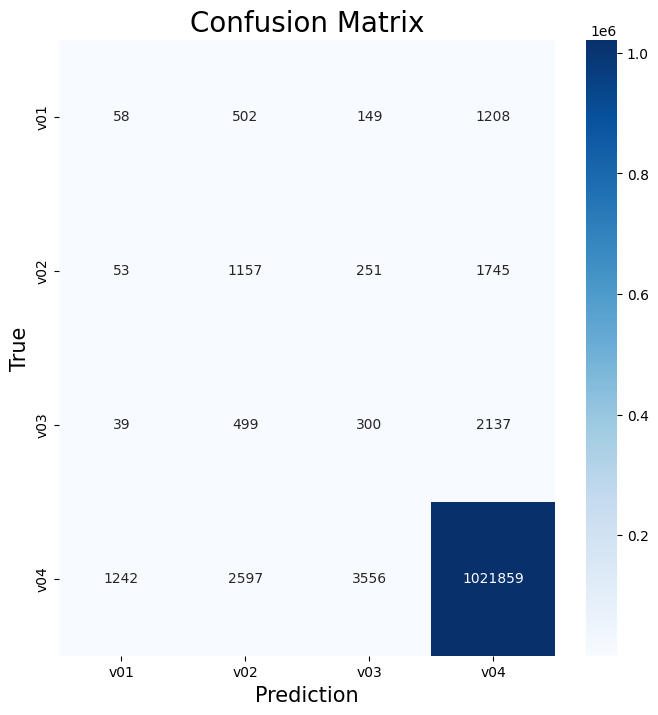

In [22]:
show_cm(y_valid, y_pred_valid)

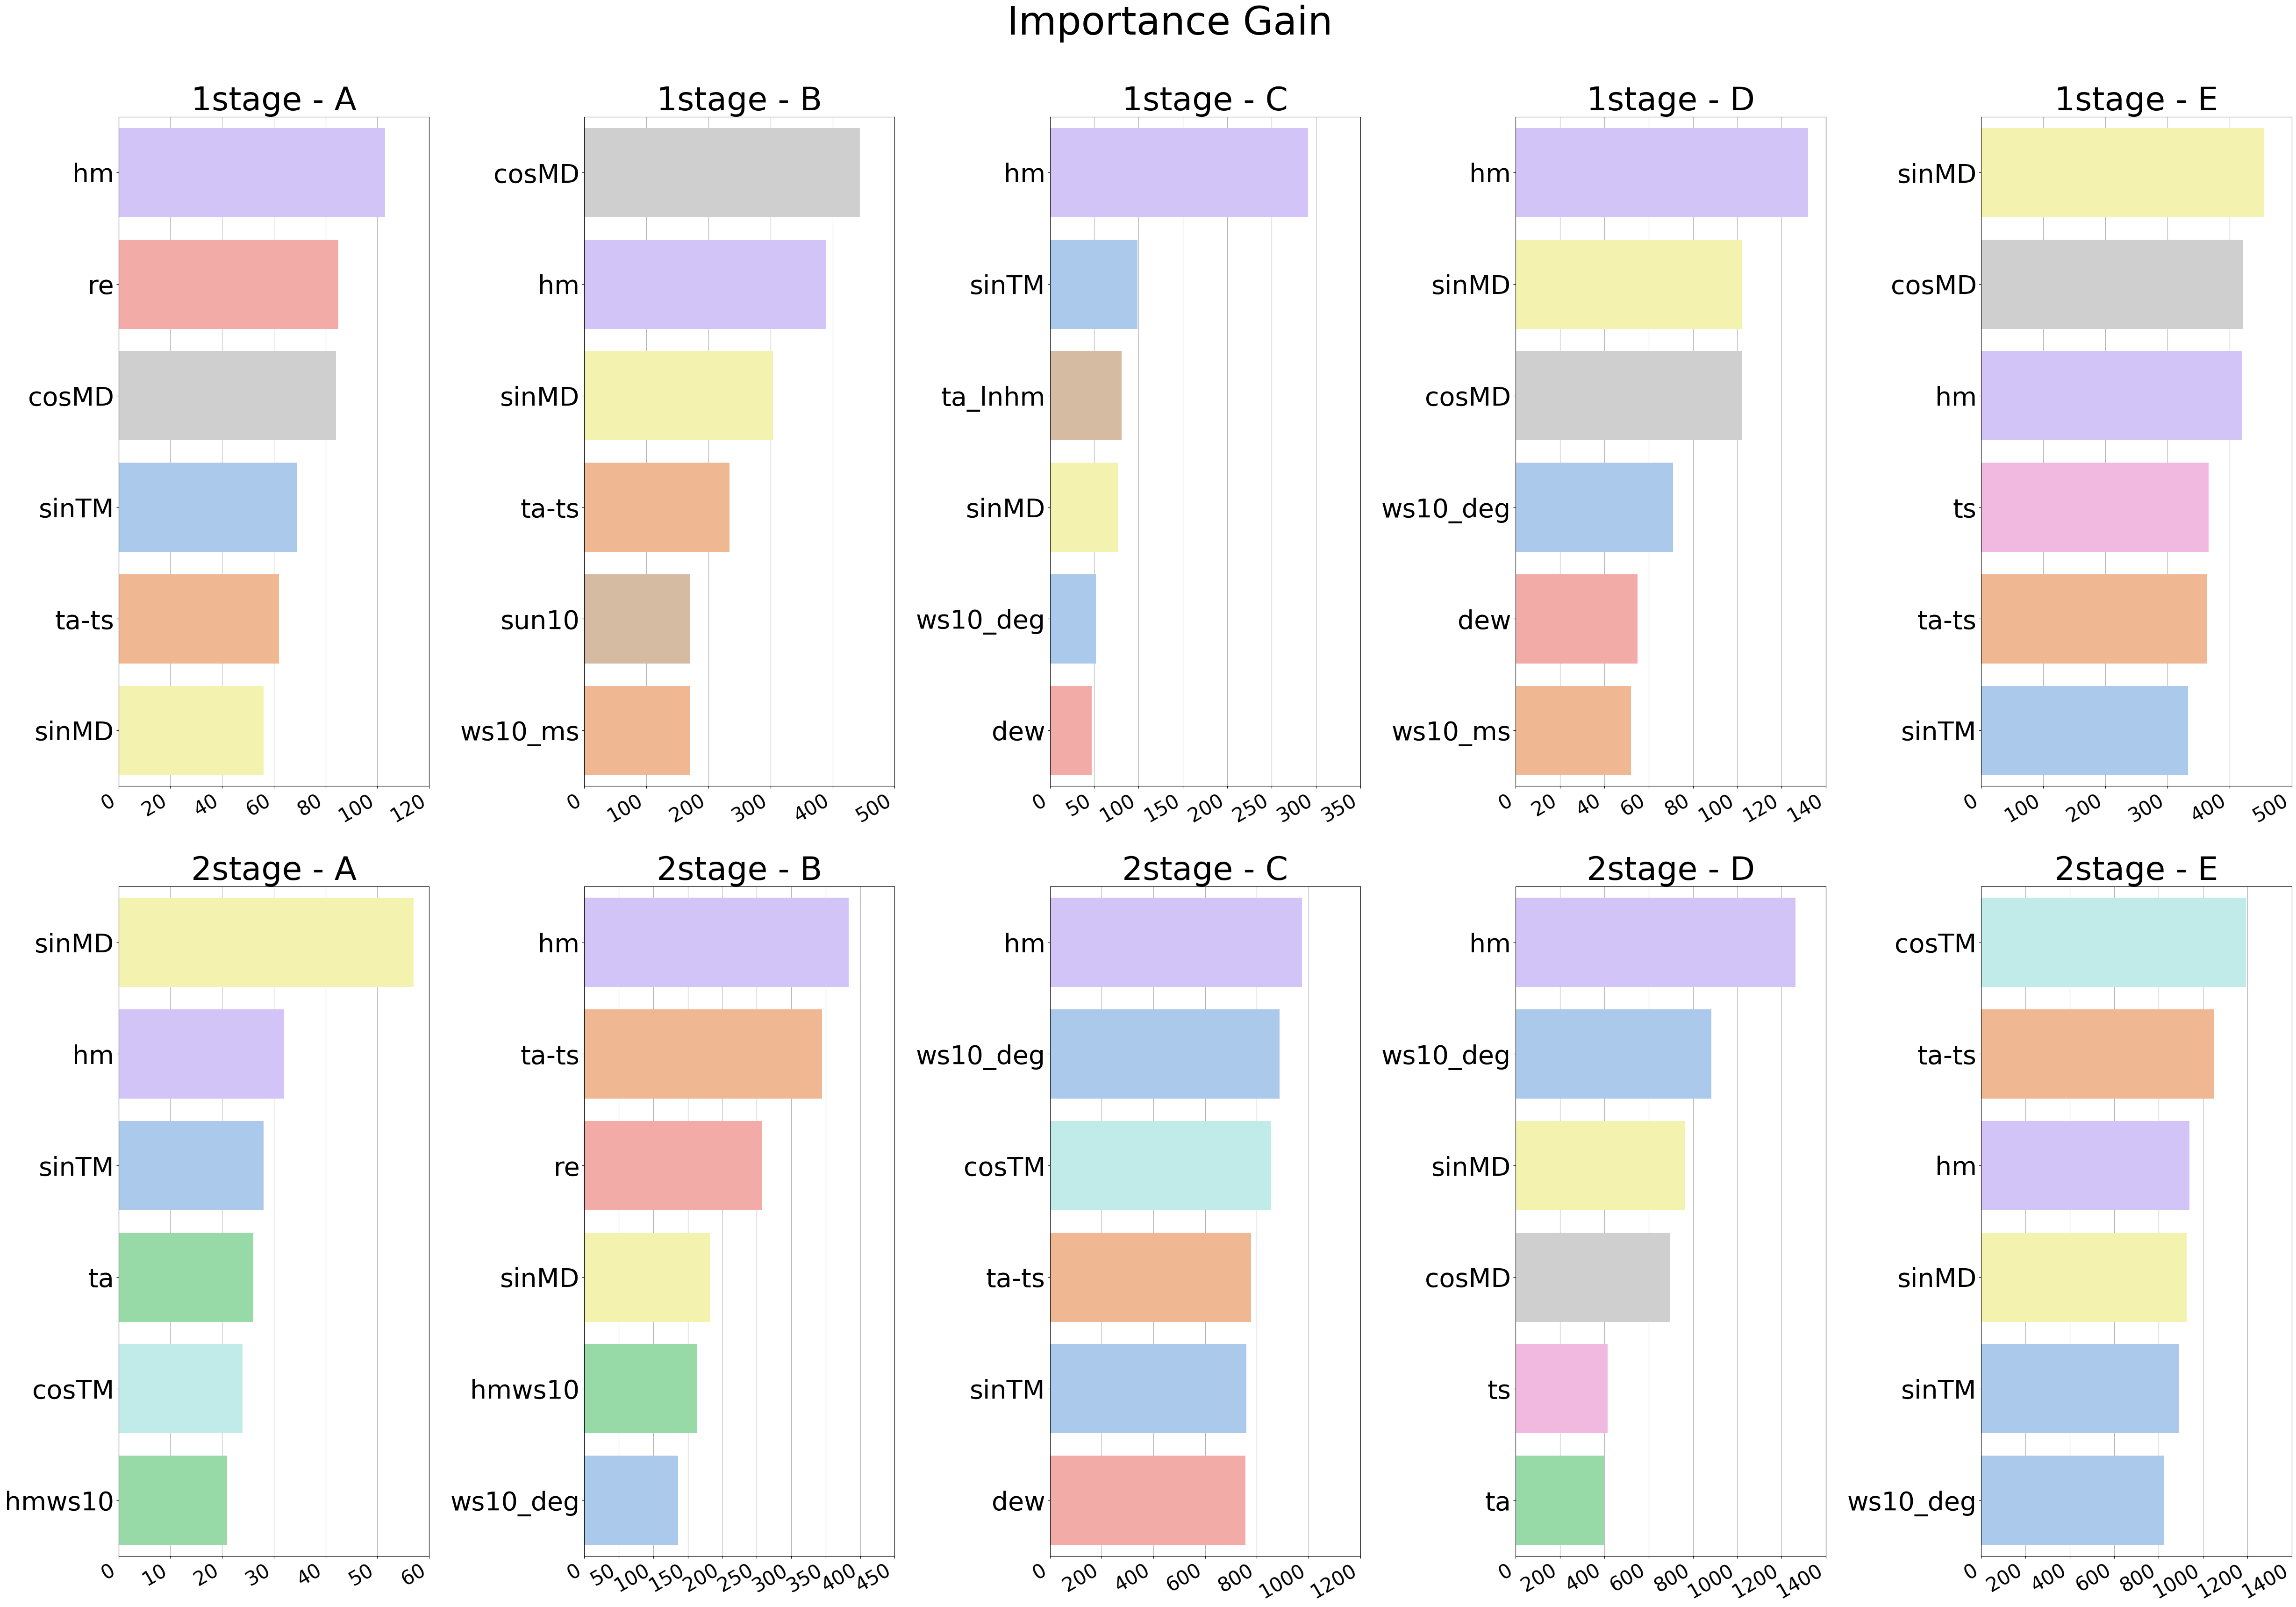

In [39]:
features = x_train01.drop('FirstLetter', axis = 1).columns
palette = sns.color_palette('pastel', len(features))
color_mapping = dict(zip(features, palette))

fig, axes = plt.subplots(2, 5, figsize = (60, 40))

for i, stage in enumerate(['1stage', '2stage']):
    for j, stn in enumerate(['A', 'B', 'C', 'D', 'E']):
        if HT.best_model['model_' + stage][stn] in ['LGBM', 'XGB']:
            importance = HT.best_model['model_' + stage][stn].booster_.feature_importance(importance_type = 'gain')
        else:
            importance = HT.best_model['model_' + stage][stn].feature_importances_
        ser = pd.Series(importance, index = x_train01.drop('FirstLetter', axis = 1, inplace = False).columns)
        ser.sort_values(ascending=False, inplace = True)
        ser = ser.iloc[:6].copy()
        # sns.barplot(x = ser, y = ser.index, ax = axes[i, j], hue = ser.index, palette = 'pastel')
        bar_colors = ser.index.map(color_mapping)
        sns.barplot(x = ser, y = ser.index, ax = axes[i, j], hue = ser.index, palette = bar_colors.to_list())
        
        xticks = axes[i, j].get_xticks()
        axes[i, j].set_xticks(xticks)
        axes[i, j].set_xticklabels([int(i) for i in xticks], fontsize = 30, rotation = 30, ha = 'right')
        
        yticks = axes[i, j].get_yticks()
        axes[i, j].set_yticks(yticks)
        axes[i, j].set_yticklabels(ser.index, fontsize = 40)
        
        axes[i, j].set_title(f"{stage} - {stn}", fontsize = 50)

        axes[i, j].grid(axis = 'x')
        axes[i, j].set_axisbelow(True)
        
        axes[i, j].set_xlabel(None)
        axes[i, j].set_ylabel(None)
fig.suptitle("Importance Gain", fontsize = 60, position = (0.5, 1 - 0.06))
# fig.tight_layout()
fig.subplots_adjust(hspace = 0.15, wspace = 0.5)

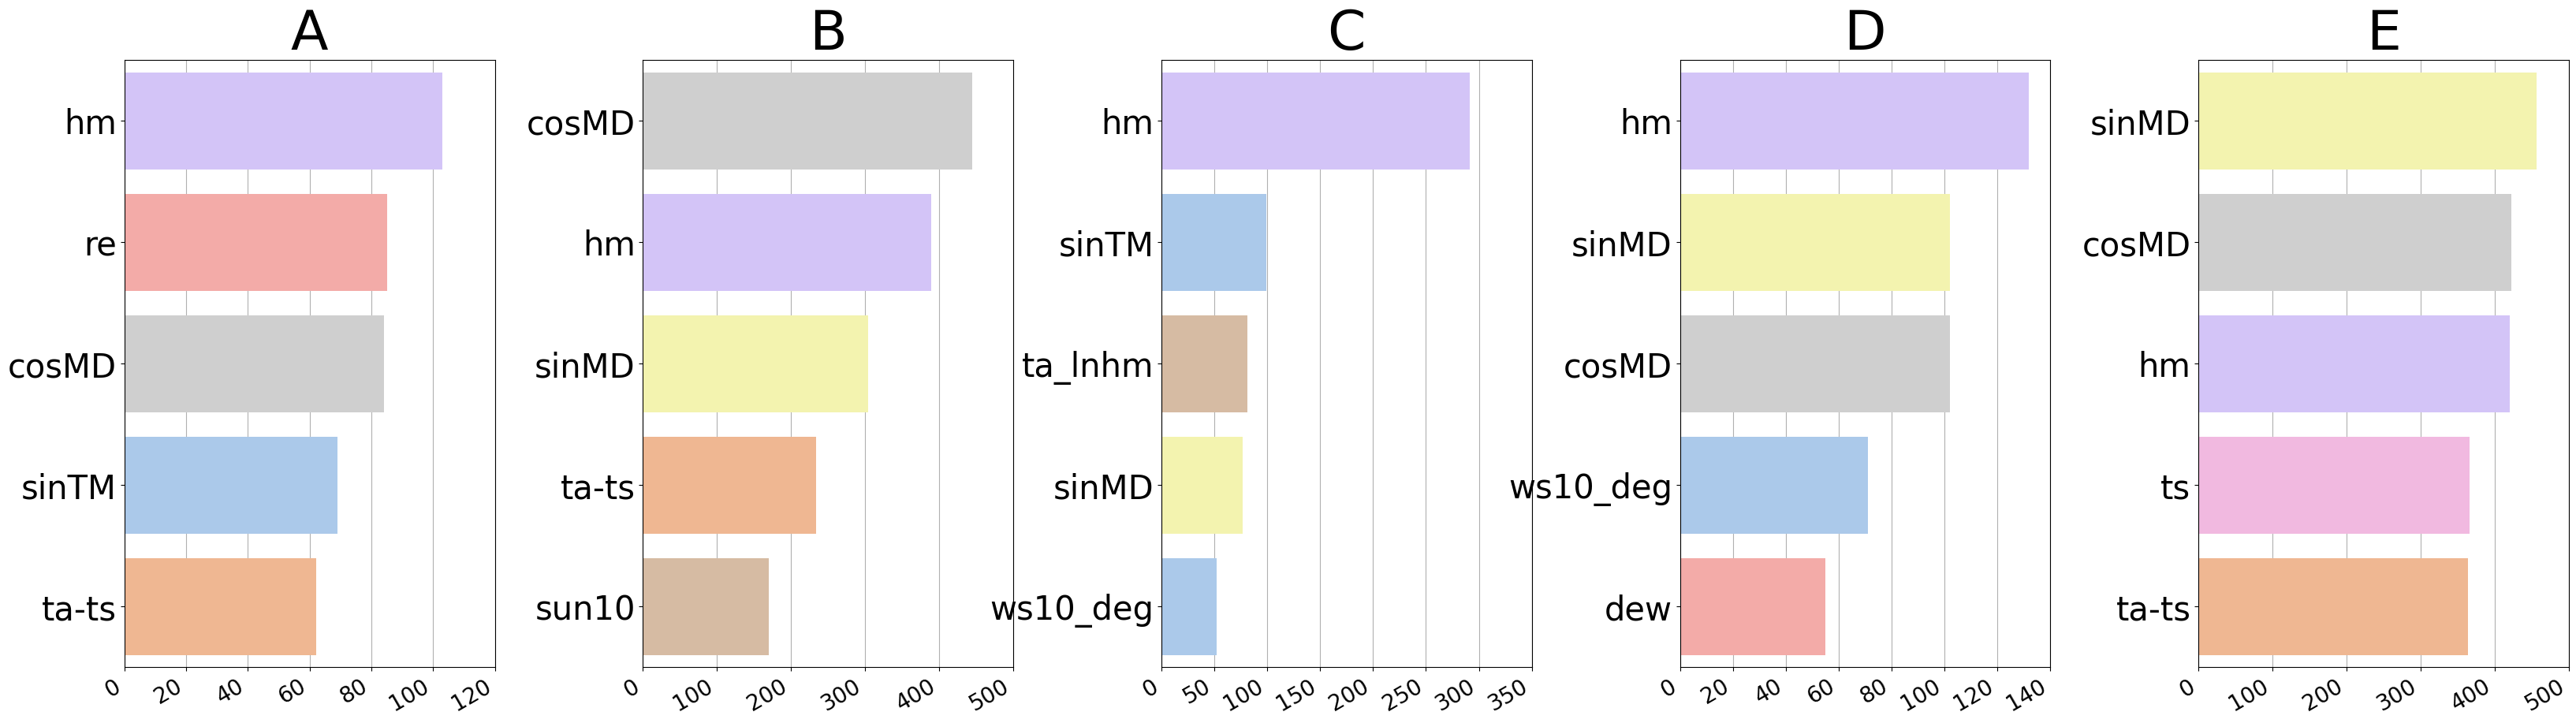

In [49]:
features = x_train01.drop('FirstLetter', axis = 1).columns
palette = sns.color_palette('pastel', len(features))
color_mapping = dict(zip(features, palette))
stage = '1stage'

fig, axes = plt.subplots(1, 5, figsize = (40, 10))

for j, stn in enumerate(['A', 'B', 'C', 'D', 'E']):
    if HT.best_model['model_' + stage][stn] in ['LGBM', 'XGB']:
        importance = HT.best_model['model_' + stage][stn].booster_.feature_importance(importance_type = 'gain')
    else:
        importance = HT.best_model['model_' + stage][stn].feature_importances_
    ser = pd.Series(importance, index = x_train01.drop('FirstLetter', axis = 1, inplace = False).columns)
    ser.sort_values(ascending=False, inplace = True)
    ser = ser.iloc[:5].copy()
    # sns.barplot(x = ser, y = ser.index, ax = axes[j], hue = ser.index, palette = 'pastel')
    bar_colors = ser.index.map(color_mapping)
    sns.barplot(x = ser, y = ser.index, ax = axes[j], hue = ser.index, palette = bar_colors.to_list())
    
    xticks = axes[j].get_xticks()
    axes[j].set_xticks(xticks)
    axes[j].set_xticklabels([int(i) for i in xticks], fontsize = 20, rotation = 30, ha = 'right')
    
    yticks = axes[j].get_yticks()
    axes[j].set_yticks(yticks)
    axes[j].set_yticklabels(ser.index, fontsize = 30)
    
    # axes[j].set_title(f"{stage} - {stn}", fontsize = 50)
    axes[j].set_title(f"{stn}", fontsize = 50)

    axes[j].grid(axis = 'x')
    axes[j].set_axisbelow(True)
    
    axes[j].set_xlabel(None)
    axes[j].set_ylabel(None)
# fig.suptitle("Importance Gain", fontsize = 60, position = (0.5, 1 - 0.06))
# fig.tight_layout()
fig.subplots_adjust(hspace = 0.15, wspace = 0.4)

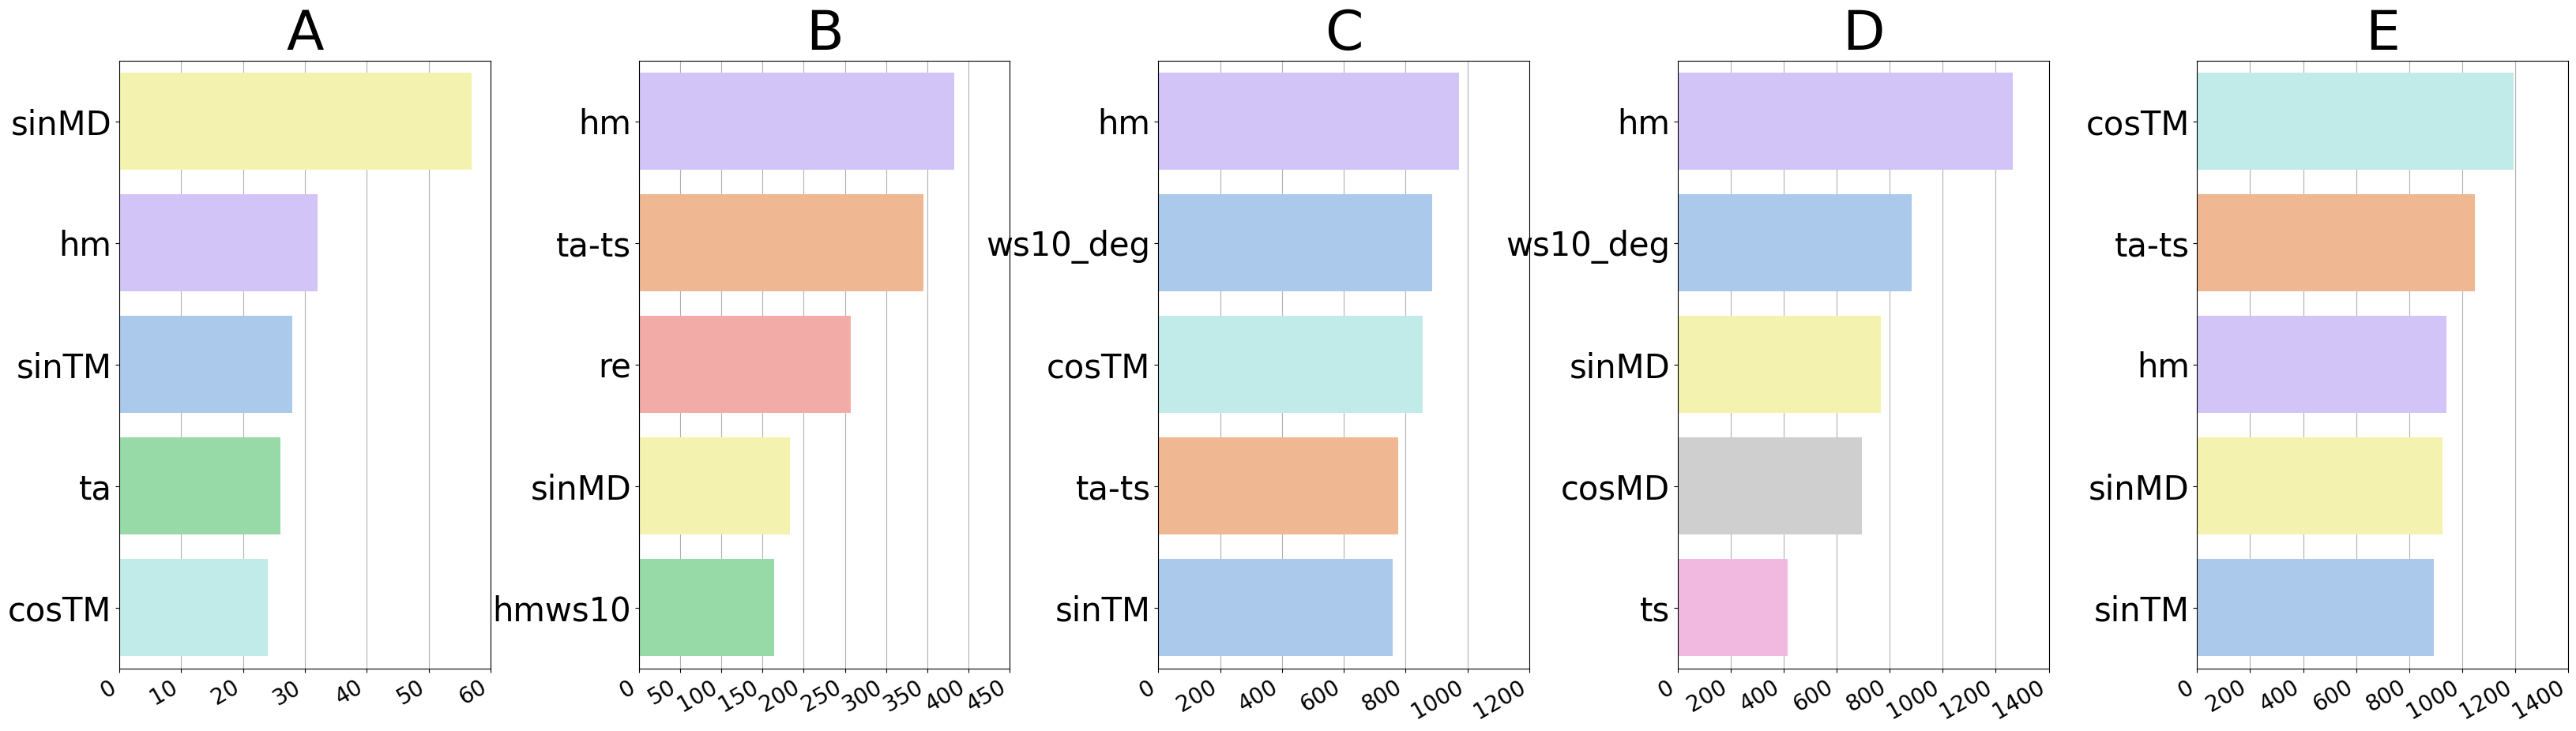

In [50]:
features = x_train01.drop('FirstLetter', axis = 1).columns
palette = sns.color_palette('pastel', len(features))
color_mapping = dict(zip(features, palette))
stage = '2stage'

fig, axes = plt.subplots(1, 5, figsize = (40, 10))

for j, stn in enumerate(['A', 'B', 'C', 'D', 'E']):
    if HT.best_model['model_' + stage][stn] in ['LGBM', 'XGB']:
        importance = HT.best_model['model_' + stage][stn].booster_.feature_importance(importance_type = 'gain')
    else:
        importance = HT.best_model['model_' + stage][stn].feature_importances_
    ser = pd.Series(importance, index = x_train01.drop('FirstLetter', axis = 1, inplace = False).columns)
    ser.sort_values(ascending=False, inplace = True)
    ser = ser.iloc[:5].copy()
    # sns.barplot(x = ser, y = ser.index, ax = axes[j], hue = ser.index, palette = 'pastel')
    bar_colors = ser.index.map(color_mapping)
    sns.barplot(x = ser, y = ser.index, ax = axes[j], hue = ser.index, palette = bar_colors.to_list())
    
    xticks = axes[j].get_xticks()
    axes[j].set_xticks(xticks)
    axes[j].set_xticklabels([int(i) for i in xticks], fontsize = 20, rotation = 30, ha = 'right')
    
    yticks = axes[j].get_yticks()
    axes[j].set_yticks(yticks)
    axes[j].set_yticklabels(ser.index, fontsize = 30)
    
    # axes[j].set_title(f"{stage} - {stn}", fontsize = 50)
    axes[j].set_title(f"{stn}", fontsize = 50)

    axes[j].grid(axis = 'x')
    axes[j].set_axisbelow(True)
    
    axes[j].set_xlabel(None)
    axes[j].set_ylabel(None)
# fig.suptitle("Importance Gain", fontsize = 60, position = (0.5, 1 - 0.06))
# fig.tight_layout()
fig.subplots_adjust(hspace = 0.15, wspace = 0.4)

## 전체 데이터로 다시 학습

In [28]:
# 실행 시간 기록 - 
HT_final = HurdleTreeModel(params = best_params_parsed)

best_model_1stage = study.best_params['model_1stage']
best_model_2stage = study.best_params['model_2stage']

for stn in ['A', 'B', 'C', 'D', 'E']:
    # 자원 사용 관련 -> GPU 사용
    best_params_parsed['params_1stage']['LGBM'][stn]['device'] = 'gpu'
    best_params_parsed['params_2stage']['LGBM'][stn]['device'] = 'gpu'

seed = 625
# random seed 설정
for stn in ['A', 'B', 'C', 'D', 'E']:
    best_params_parsed['params_1stage'][best_model_1stage][stn]['random_state'] = seed
    best_params_parsed['params_2stage'][best_model_2stage][stn]['random_state'] = seed

for model in ['XGB', 'LGBM', 'RNF']:
    if model != best_model_1stage:
        del HT_final.model_1stage[model]
for model in ['XGB', 'LGBM', 'RNF']:
    if model != best_model_2stage:
        del HT_final.model_2stage[model] 

HT_final.fit_1stage(x_train01_final, y_train01_final)
HT_final.cutoffs = cutoff_dict
HT_final.set_1stage_model(best_model_1stage)
HT_final.fit_2stage(x_train123_final, y_train123_final)
HT_final.set_2stage_model(best_model_2stage)

## test

In [29]:
test = pd.read_csv('../data/test_final.csv')

In [30]:
test = gen_derived_variables(test)

In [31]:
test

,stn_id,year,month,day,time,minute,FirstLetter,SecondLetter,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,class,MDay,TM,cosMD,sinMD,cosTM,sinTM,ta-ts,hmws10,dew,half,ta_lnhm,sup_dew
0,AI,L,1,1,0,0,A,I,329.5,0.6,-2.5,0.0,87.5,0.0,-1.6,NaN,1,0,0.999852,1.721336e-02,1.000000,0.000000,-0.9,0.006857,-4.291327,0,-0.477666,False
1,AI,L,1,1,0,10,A,I,321.8,1.2,-2.5,0.0,88.2,0.0,-1.6,NaN,1,10,0.999852,1.721336e-02,0.999048,0.043619,-0.9,0.013605,-4.185183,0,-0.477326,False
2,AI,L,1,1,0,20,A,I,0.4,0.4,-2.5,0.0,88.6,0.0,-1.7,NaN,1,20,0.999852,1.721336e-02,0.996195,0.087156,-0.8,0.004515,-4.124864,0,-0.477133,False
3,AI,L,1,1,0,30,A,I,323.6,0.7,-2.6,0.0,88.7,0.0,-1.6,NaN,1,30,0.999852,1.721336e-02,0.991445,0.130526,-1.0,0.007892,-4.208489,0,-0.496168,False
4,AI,L,1,1,0,40,A,I,208.4,0.2,-2.6,0.0,89.0,0.0,-1.6,NaN,1,40,0.999852,1.721336e-02,0.984808,0.173648,-1.0,0.002247,-4.163491,0,-0.496018,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262795,ED,L,12,31,23,10,E,D,338.8,6.1,4.5,0.0,71.3,0.0,1.9,NaN,365,1390,1.000000,6.432571e-16,0.976296,-0.216440,2.6,0.085554,-0.249011,0,0.874905,False
262796,ED,L,12,31,23,20,E,D,335.2,5.8,4.6,0.0,71.4,0.0,1.9,NaN,365,1400,1.000000,6.432571e-16,0.984808,-0.173648,2.7,0.081232,-0.133495,0,0.894246,False
262797,ED,L,12,31,23,30,E,D,337.1,5.3,4.5,0.0,72.1,0.0,1.8,NaN,365,1410,1.000000,6.432571e-16,0.991445,-0.130526,2.7,0.073509,-0.095276,0,0.874113,False
262798,ED,L,12,31,23,40,E,D,322.0,3.7,4.3,0.0,72.5,0.0,1.4,NaN,365,1420,1.000000,6.432571e-16,0.996195,-0.087156,2.9,0.051034,-0.211744,0,0.834887,False


In [32]:
# 지역 구분을 위해 FirstLetter 필요
drop_cols_test = ['year', 'month', 'day', 'time', 'minute', 'MDay', 'TM', # 시간 관련 변수 -> cos/sin MD/TM 으로 압축
                  'stn_id', 'SecondLetter', # 지역 변수
                  'class'] # 타겟 변수
x_test = test.drop(drop_cols_test, axis = 1, inplace = False).copy()
x_test = x_test[x_train01.columns] # 학습 때와 동일한 열 순서를 같도록 설정

y_pred = HT_final.predict_oneshot(x_test)

In [33]:
raw_test = pd.read_csv('../data/fog_test.csv')
raw_test['fog_test.class'] = y_pred

In [34]:
from collections import Counter
Counter(y_pred)

Counter({4: 257788, 1: 704, 3: 1316, 2: 2992})

In [35]:
print(sum(raw_test['fog_test.class'].isna()))

0


In [36]:
raw_test

,fog_test.year,fog_test.month,fog_test.day,fog_test.time,fog_test.minute,fog_test.stn_id,fog_test.ws10_deg,fog_test.ws10_ms,fog_test.ta,fog_test.re,fog_test.hm,fog_test.sun10,fog_test.ts,fog_test.class
0,L,1,1,0,0,AI,329.5,0.6,-2.5,0.0,87.5,0.0,-1.6,4
1,L,1,1,0,10,AI,321.8,1.2,-2.5,0.0,88.2,0.0,-1.6,4
2,L,1,1,0,20,AI,0.4,0.4,-2.5,0.0,88.6,0.0,-1.7,4
3,L,1,1,0,30,AI,323.6,0.7,-2.6,0.0,88.7,0.0,-1.6,4
4,L,1,1,0,40,AI,208.4,0.2,-2.6,0.0,89.0,0.0,-1.6,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262795,L,12,31,23,10,ED,338.8,6.1,4.5,0.0,71.3,0.0,1.9,4
262796,L,12,31,23,20,ED,335.2,5.8,4.6,0.0,71.4,0.0,1.9,4
262797,L,12,31,23,30,ED,337.1,5.3,4.5,0.0,72.1,0.0,1.8,4
262798,L,12,31,23,40,ED,322.0,3.7,4.3,0.0,72.5,0.0,1.4,4


In [ ]:
raw_test.to_csv("../data/prediction/pred_HT.csv", index = False)

In [79]:
joblib.dump(HT_final, '../model/HurdleTree_final.joblib')

['../model/HurdleTree_final.joblib']

In [80]:
model_load_test = joblib.load('../model/HurdleTree_final.joblib')

In [82]:
print(model_load_test.best_1stage_key)
print(model_load_test.cutoffs)

LGBM
{'XGB': {'A': -1, 'B': -1, 'C': -1, 'D': -1, 'E': -1}, 'LGBM': {'A': 0.165, 'B': 0.155, 'C': 0.035, 'D': 0.08, 'E': 0.09}, 'RNF': {'A': -1, 'B': -1, 'C': -1, 'D': -1, 'E': -1}}
